In [1]:
# # Install needed libraries
# !python -m pip install import_ipynb 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from crunch_func import *

In [2]:
try:
    engine_df = pd.read_csv("EngineData.txt", sep='\t')
except FileNotFoundError:
        print("Engine Data file found. Make sure file is in same directory and name is correct.")

In [3]:
print("*** DATA SET 1700 ***")
cd1700, data_cleaned = load_data("clean_1700.csv",'1700_001.txt')
if data_cleaned == False:
    cd1700 = clean_data(cd1700, 8, 9, 8, 0.2)
eng1_data = engine_df.iloc[0]
load = eng1_data["Load"]
espeed = eng1_data["Engine Speed (rpm)"]
torque = eng1_data["Torque (lb-f)"]
power = eng1_data["Power (hp)"]
time_2_leave = eng1_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng1_data["Air Flow Rate (CFM)"]
air_in_temp = eng1_data["Air Intake Temperature (F)"]
print('Engine Data Loaded')
cd1700.to_csv('clean_1700.csv', index=False)
print('Created new CSV with cleaned crunched data')


*** DATA SET 1700 ***
Found clean_1700.csv, CSV converted into dataframe.
Engine Data Loaded
Created new CSV with cleaned crunched data


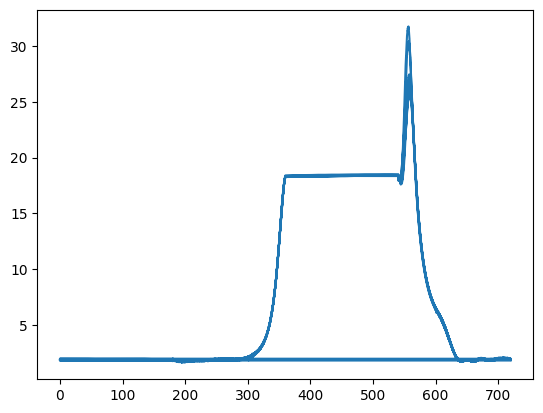

In [4]:
plt.plot(cd1700['rel_crank_ang'], cd1700['pressure_bar'])

Text(0, 0.5, 'Pressure [Bar]')

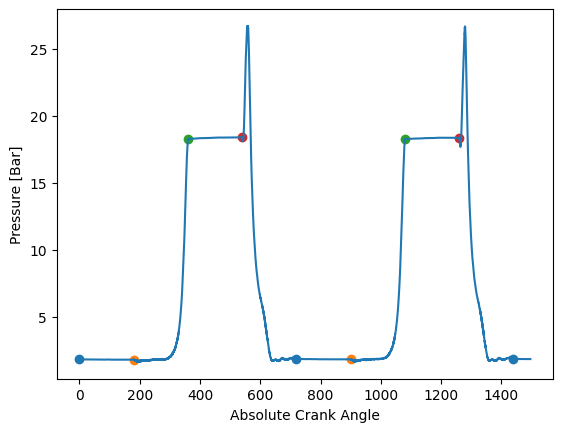

In [5]:
cd1700_range = cd1700[cd1700['abs_crank_ang'] < 1500]
state_points = cd1700_range.dropna(subset=['crank_state'])
state1 = state_points[state_points['crank_state'] == 1]
state2 = state_points[state_points['crank_state'] == 2]
state3 = state_points[state_points['crank_state'] == 3]
state4 = state_points[state_points['crank_state'] == 4]
state5 = state_points[state_points['crank_state'] == 5]
plt.plot(cd1700_range['abs_crank_ang'], cd1700_range['pressure_bar'])
# plt.scatter(state_points['abs_crank_ang'], state_points['pressure_bar'])
plt.scatter(state1['abs_crank_ang'], state1['pressure_bar'])
plt.scatter(state2['abs_crank_ang'], state2['pressure_bar'])
plt.scatter(state3['abs_crank_ang'], state3['pressure_bar'])
plt.scatter(state4['abs_crank_ang'], state4['pressure_bar'])
# plt.scatter(state5['abs_crank_ang'], state5['pressure_bar'])
plt.xlabel("Absolute Crank Angle")
plt.ylabel("Pressure [Bar]")


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_bc_list(df, consec_crankv, bound):
    cycles = 0
    max_consec_crank = 0
    # Getting Top Center Points
    bc_list = []
    v_count = 1
    for i in range(len(df)):
        if v_count > max_consec_crank:
            max_consec_crank = v_count
        if (v_count == 1) & (df['crank_v'].iloc[i] > 9):
            bc_start = df.index[i]
        if (df['crank_v'].iloc[i-1] > bound) & (df['crank_v'].iloc[i] > bound):
            v_count += 1
        if (v_count >= consec_crankv) & (df['crank_v'].iloc[i] > bound):
            bc_list.append(bc_start)
            v_count = 1
            cycles += 1
        if df['crank_v'].iloc[i] < bound:
            v_count = 1 
    if cycles == 0:
        print(f"{consec_crankv} consecutive {bound}V Crank angle readings not found")
        print(f"Longest recuring voltage reading above {bound} is {max_consec_crank}")
        print("Bottom Center Points Not Found")
        return []
    print("Bottom Center Points Found")
    return bc_list

def get_tc_list(df, consec_crankv, bound):
    cycles = 0
    max_consec_crank = 0
    # Getting Top Center Points
    tc_list = []
    v_count = 1
    for i in range(len(df)):
        if v_count > max_consec_crank:
            max_consec_crank = v_count
        if (v_count == 1) & (df['crank_v'].iloc[i] < bound):
            tc_start = df.index[i]
        if (df['crank_v'].iloc[i-1] < bound) & (df['crank_v'].iloc[i] < bound):
            v_count += 1
        if (v_count >= consec_crankv) & (df['crank_v'].iloc[i] > bound):
            tc_list.append(tc_start)
            v_count = 1
            cycles += 1
        if df['crank_v'].iloc[i] > bound:
            v_count = 1 
    if cycles == 0:
        print(f"{consec_crankv} consecutive {bound}V Crank angle readings not found")
        print(f"Longest recuring voltage reading below {bound} is {max_consec_crank}")
        print("Top Center Points Not Found")
        return []
    print("Top Center Points Found")
    return tc_list

def set_tc_states(df, tc_list):
    state = 1
    add_list = []
    for i in range(len(tc_list)):
        index = tc_list[i]
        if state == 1:
            df.loc[index, 'crank_state'] = 5
            df.loc[index, 'rel_crank_ang'] = 720
            df.loc[index + 1, 'crank_state'] = state
            df.loc[index + 1, 'rel_crank_ang'] = 0
            add_list.append(index + 1)
            state = 3
            continue
        if state == 3:
            df.loc[index, 'crank_state'] = state
            df.loc[index, 'rel_crank_ang'] = 360
            state = 1
            continue
    tc_list += add_list
    tc_list.sort()
    return tc_list

def set_bc_states(df, bc_list):
    state = 2
    rel_crank_ang = 180
    for i in range(len(bc_list)):
        index = bc_list[i]
        df.loc[index, 'crank_state'] = state
        df.loc[index, 'rel_crank_ang'] = rel_crank_ang
        state += 2
        rel_crank_ang += 360
        if state > 5:
            state = 2
            rel_crank_ang = 180
    return bc_list

def create_avged_states(known_list):
    new_list = []
    for i in range(len(known_list)):
        if i == len(known_list) - 1: continue
        new_list.append((known_list[i] +  known_list[i+1])//2)
    return new_list

def scale_pressure(df):
    df['pressure_bar'] = df['pressure_v'] * 10.2
    return df

def set_crank_states(df, bc_consec, bc_bound, tc_consec, tc_bound):
    tc_list = get_tc_list(df, tc_consec, tc_bound)
    if len(tc_list) != 0:
        tc_list = set_tc_states(df, tc_list)
    
    bc_list = get_bc_list(df, bc_consec, bc_bound)
    if len(bc_list) != 0:
        bc_list = set_bc_states(df, bc_list)

# This permutation should never happen with the data that we have
    if (len(bc_list) == 0) & (len(tc_list) != 0):
        bc_list = create_avged_states(tc_list)
        bc_list = set_bc_states(df, bc_list)
        print("something went wrong, this code should not be called")

# This is the permutation that should be expected
    elif (len(tc_list) == 0) & (len(bc_list) != 0):
        tc_list = create_avged_states(bc_list)
        # Since we are taking bottom center as the start of the cycle, start state is state 2, thus tc start should be 3.
        state = 3
        add_list = []
        for i in range(len(tc_list)):
            index = tc_list[i]
            if state == 1:
                df.loc[index, 'crank_state'] = 5
                df.loc[index, 'rel_crank_ang'] = 720
                df.loc[index + 1, 'crank_state'] = state
                df.loc[index + 1, 'rel_crank_ang'] = 0
                add_list.append(index + 1)
                state = 3
                continue
            if state == 3:
                df.loc[index, 'crank_state'] = state
                df.loc[index, 'rel_crank_ang'] = 360
                state = 1
                continue
        tc_list += add_list
        tc_list.sort()
        
    if (len(bc_list) == 0) & (len(tc_list) == 0):
        print("Could not get consitent voltage readings to find crank angle states.")
        return df
    
    state_list = tc_list + bc_list
    
    state_list.sort()
    # Interpolation of mid points for crank angles
    for i in range(len(state_list)):
        if i == len(state_list) - 1:
            continue
        index = state_list[i]
        ang1 =  df.loc[df.index[state_list[i]], 'rel_crank_ang']
        dp1 = state_list[i]
        ang2 = df.loc[df.index[state_list[i+1]], 'rel_crank_ang']
        dp2 = state_list[i+1]
        slope = (ang2 - ang1)/(dp2-dp1)
        points_to_inter = dp2 - dp1
        for inter_point in range(points_to_inter):
            inter_ang = ang2-(slope*(dp2 - (dp1 + inter_point)))
            df.loc[df.index[dp1 + inter_point],'rel_crank_ang'] = inter_ang
    print("Interpolated Relative Crank Angles")
    df = df.dropna(subset=['rel_crank_ang']) 
    
    # Calculating absolute crank angle
    for i in range(len(df)):
        index = df.index[i]
        if i == 0:
            df.loc[index, 'abs_crank_ang'] = 0
            continue
        if abs(df.loc[index, 'rel_crank_ang'] - df.loc[index-1, 'rel_crank_ang']) > 100:
            df.loc[index, 'abs_crank_ang'] = df.loc[index-1, 'abs_crank_ang']
            continue
        abs_ang = df.loc[index-1, 'abs_crank_ang'] + df.loc[index, 'rel_crank_ang'] - df.loc[index-1, 'rel_crank_ang']
        df.loc[index, 'abs_crank_ang'] = abs_ang
    print("Calculated Absolute Crank Angles")
    return df

def clean_data(df, bc_consec, bc_bound, tc_consec, tc_bound):
    df = scale_pressure(df)
    df = set_crank_states(df, bc_consec, bc_bound, tc_consec, tc_bound)
    return df

# Load Data
## Load data will look for cleaned data, if cleaned data does not exist, it will look for raw data. 
## Raw data will be cleaned and returned as a Pandas Dataframe. A csv file will also be created with cleaned data. 
## Parsing raw data will take about 30 seconds
def load_data(csv_name, txt_name):
    try:
        df = pd.read_csv(csv_name)
        print(f"Found {csv_name}, CSV converted into dataframe.")
        return df, True
    except FileNotFoundError:
        try:
            print(f"{csv_name} not found. Will try to load {txt_name} raw data.")
            # Time [s], Crank Angle [V], Pressure [V]
            df = pd.read_csv(txt_name, sep='\t', names=['time', 'crank_v', 'pressure_v'])
            print(f"{txt_name} file found, processing data and converting to dataframe.")
            print("Returned as Pandas Dataframe. Data not crunched")
            return df, False
        except FileNotFoundError:
            print(f"{txt_name} raw data not found, please put {txt_name} file in same directory as this ipynb file.")
            return False, False

In [50]:
print("*** DATA SET 2730 ***")
cd2730, data_cleaned = load_data("clean_2730.csv",'2750_001.txt')
# Clean data takes 5 arguments (DataFrame, BC Repeat len, BC Volt Cutoff, TC Repeat Len, TC Volt Cutoff)
if data_cleaned == False:
    cd2730 = clean_data(cd2730, 5, 5, 8, 0.25)
eng2_data = engine_df.iloc[1]
load = eng2_data["Load"]
espeed = eng2_data["Engine Speed (rpm)"]
torque = eng2_data["Torque (lb-f)"]
power = eng2_data["Power (hp)"]
time_2_leave = eng2_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng2_data["Air Flow Rate (CFM)"]
air_in_temp = eng2_data["Air Intake Temperature (F)"]
# print('Engine Data Loaded')
# cd2730.to_csv('clean_2730.csv', index=False)
# print('Created new CSV with cleaned crunched data')

*** DATA SET 2730 ***
clean_2730.csv not found. Will try to load 2750_001.txt raw data.
2750_001.txt file found, processing data and converting to dataframe.
Returned as Pandas Dataframe. Data not crunched
Top Center Points Found
Bottom Center Points Found
Interpolated Relative Crank Angles


C:\Users\joshu\AppData\Local\Temp\ipykernel_17392\3155878911.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'abs_crank_ang'] = 0


Calculated Absolute Crank Angles


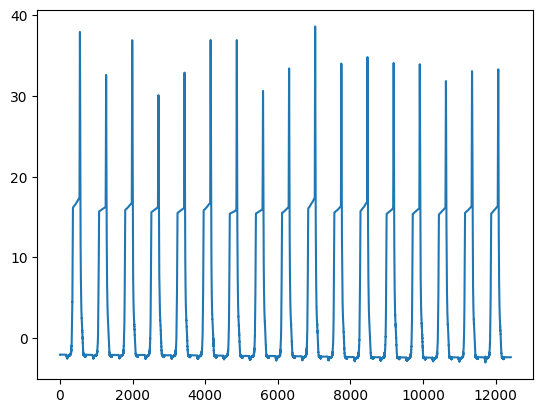

In [51]:
plt.plot(cd2730['abs_crank_ang'], cd2730['pressure_bar'])

Text(0, 0.5, 'Pressure [Bar]')

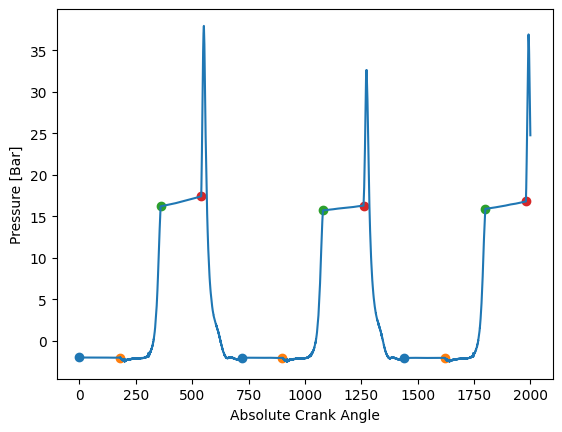

In [52]:
cd2730_range = cd2730[cd2730['abs_crank_ang'] < 2000]
state_points = cd2730_range.dropna(subset=['crank_state'])
state1 = state_points[state_points['crank_state'] == 1]
state2 = state_points[state_points['crank_state'] == 2]
state3 = state_points[state_points['crank_state'] == 3]
state4 = state_points[state_points['crank_state'] == 4]
state5 = state_points[state_points['crank_state'] == 5]
plt.plot(cd2730_range['abs_crank_ang'], cd2730_range['pressure_bar'])
# plt.scatter(state_points['abs_crank_ang'], state_points['pressure_bar'])
plt.scatter(state1['abs_crank_ang'], state1['pressure_bar'])
plt.scatter(state2['abs_crank_ang'], state2['pressure_bar'])
plt.scatter(state3['abs_crank_ang'], state3['pressure_bar'])
plt.scatter(state4['abs_crank_ang'], state4['pressure_bar'])
# plt.scatter(state5['abs_crank_ang'], state5['pressure_bar'])
plt.xlabel("Absolute Crank Angle")
plt.ylabel("Pressure [Bar]")

In [85]:
print("*** DATA SET cd4500 ***")
cd4500, data_cleaned = load_data("clean_4500.csv",'4500_001.txt')
# Clean data takes 5 arguments (DataFrame, BC Repeat len, BC Volt Cutoff above 10 or something like that, TC Repeat Len, TC Volt Cutoff below 0.2 or something like that)
if data_cleaned == False:
    cd4500 = clean_data(cd4500, 8, 5, 9, 1)
eng3_data = engine_df.iloc[2]
load = eng3_data["Load"]
espeed = eng3_data["Engine Speed (rpm)"]
torque = eng3_data["Torque (lb-f)"]
power = eng3_data["Power (hp)"]
time_2_leave = eng3_data["Time for 0.488 L of fuel to leave Burette (s)"]
air_flow_rate = eng3_data["Air Flow Rate (CFM)"]
air_in_temp = eng3_data["Air Intake Temperature (F)"]
# print('Engine Data Loaded')
# cd4500.to_csv('clean_4500.csv', index=False)
# print('Created new CSV with cleaned crunched data')

*** DATA SET cd4500 ***
clean_4500.csv not found. Will try to load 4500_001.txt raw data.
4500_001.txt file found, processing data and converting to dataframe.
Returned as Pandas Dataframe. Data not crunched
9 consecutive 1V Crank angle readings not found
Longest recuring voltage reading below 1 is 6
Top Center Points Not Found
Bottom Center Points Found
Interpolated Relative Crank Angles


C:\Users\joshu\AppData\Local\Temp\ipykernel_17392\3155878911.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'abs_crank_ang'] = 0


Calculated Absolute Crank Angles


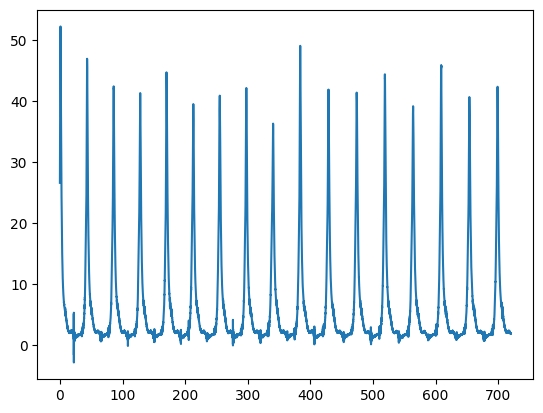

In [86]:
plt.plot(cd4500['abs_crank_ang'], cd4500['pressure_bar'])

Text(0, 0.5, 'Pressure [Bar]')

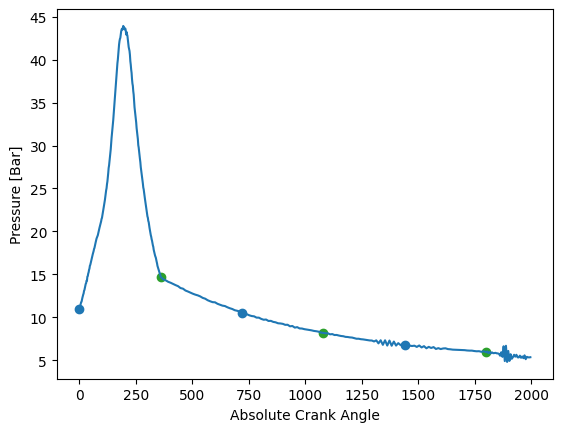

In [80]:
cd4500_range = cd4500[cd4500['abs_crank_ang'] < 2000]
state_points = cd4500_range.dropna(subset=['crank_state'])
state1 = state_points[state_points['crank_state'] == 1]
state2 = state_points[state_points['crank_state'] == 2]
state3 = state_points[state_points['crank_state'] == 3]
state4 = state_points[state_points['crank_state'] == 4]
state5 = state_points[state_points['crank_state'] == 5]
plt.plot(cd4500_range['abs_crank_ang'], cd4500_range['pressure_bar'])
# plt.scatter(state_points['abs_crank_ang'], state_points['pressure_bar'])
plt.scatter(state1['abs_crank_ang'], state1['pressure_bar'])
plt.scatter(state2['abs_crank_ang'], state2['pressure_bar'])
plt.scatter(state3['abs_crank_ang'], state3['pressure_bar'])
plt.scatter(state4['abs_crank_ang'], state4['pressure_bar'])
# plt.scatter(state5['abs_crank_ang'], state5['pressure_bar'])
plt.xlabel("Absolute Crank Angle")
plt.ylabel("Pressure [Bar]")